In [1]:
import pandas as pd
import os
import csv
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Load Zillow Home Value Index (ZHVI) Data

In [2]:
state_zhvi_df = pd.read_csv('/content/data/State_Zhvi_AllHomes.csv')
display(state_zhvi_df.head())

,Unnamed: 0,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,0,9,0,California,State,CA,162238.0,162008.0,161859.0,161569.0,...,555305.0,556199.0,557569.0,559490.0,561495.0,563523.0,566433.0,569813.0,573975.0,578267.0
1,1,54,1,Texas,State,TX,97631.0,97656.0,97684.0,97811.0,...,206423.0,207079.0,207699.0,208380.0,208865.0,209358.0,209723.0,210164.0,210591.0,211199.0
2,2,43,2,New York,State,NY,139108.0,138793.0,138607.0,138327.0,...,323518.0,324039.0,324498.0,324903.0,325371.0,325925.0,326646.0,327360.0,328101.0,328677.0
3,3,14,3,Florida,State,FL,100595.0,100691.0,100803.0,101013.0,...,244754.0,245385.0,245996.0,246632.0,247345.0,248103.0,248825.0,249766.0,250981.0,252309.0
4,4,21,4,Illinois,State,IL,139112.0,138861.0,138544.0,138172.0,...,203158.0,203458.0,203678.0,203788.0,203850.0,203907.0,204058.0,204302.0,204527.0,204839.0



## **DATA LOADING AND CLEANING**

The datasets are stored in the /content/data/ folder, with each file representing a different feature that we want to include in our dataset. As part of data loading, we modify all these different datasets and combine them based on state, month, and year.

The Age folder inside /content/data/ contains demographic distributions by age across different years. State_Zhvi_AllHomes is the target variable we are trying to predict, where ZHVI stands for Zillow Home Value Index.

For more details on how Zillow calculates the Home Value Index, refer toto https://www.zillow.com/research/zhvi-user-guide/

In [3]:
print(state_zhvi_df.isnull().sum())

Unnamed: 0    0
RegionID      0
SizeRank      0
RegionName    0
RegionType    0
             ..
2019-11-30    0
2019-12-31    0
2020-01-31    0
2020-02-29    0
2020-03-31    0
Length: 297, dtype: int64


In [4]:
# Iterate through the columns and identify date columns by attempting to convert them to datetime objects.
date_cols = []
for col in state_zhvi_df.columns:
    try:
        pd.to_datetime(col)
        date_cols.append(col)
    except ValueError:
        pass
date_cols_series = pd.Series(date_cols)
date_cols_datetime = pd.to_datetime(date_cols_series)
mask_2008_onwards = date_cols_datetime.dt.year >= 2008
date_cols_2008_onwards = date_cols_series[mask_2008_onwards].tolist()
date_cols_2008_onwards = [col for col in date_cols if pd.to_datetime(col).year >= 2008]
# Create a list of columns to drop and then drop them from the dataframe.
cols_to_drop = [col for col in date_cols if col not in date_cols_2008_onwards]
state_zhvi_df.drop(columns=cols_to_drop, inplace=True)
display(state_zhvi_df.head())

,Unnamed: 0,RegionID,SizeRank,RegionName,RegionType,StateName,2008-01-31,2008-02-29,2008-03-31,2008-04-30,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,0,9,0,California,State,CA,465554.0,456340.0,445900.0,434567.0,...,555305.0,556199.0,557569.0,559490.0,561495.0,563523.0,566433.0,569813.0,573975.0,578267.0
1,1,54,1,Texas,State,TX,143090.0,142690.0,142136.0,141788.0,...,206423.0,207079.0,207699.0,208380.0,208865.0,209358.0,209723.0,210164.0,210591.0,211199.0
2,2,43,2,New York,State,NY,289335.0,288912.0,288472.0,287775.0,...,323518.0,324039.0,324498.0,324903.0,325371.0,325925.0,326646.0,327360.0,328101.0,328677.0
3,3,14,3,Florida,State,FL,238292.0,234155.0,229628.0,225318.0,...,244754.0,245385.0,245996.0,246632.0,247345.0,248103.0,248825.0,249766.0,250981.0,252309.0
4,4,21,4,Illinois,State,IL,228473.0,226266.0,225562.0,223157.0,...,203158.0,203458.0,203678.0,203788.0,203850.0,203907.0,204058.0,204302.0,204527.0,204839.0


In [5]:
#Iterate through the columns and identify date columns by attempting to convert them to datetime objects.
date_cols = []
for col in state_zhvi_df.columns:
    try:
        pd.to_datetime(col)
        date_cols.append(col)
    except ValueError:
        pass

print(date_cols)

['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31', '2008-09-30', '2008-10-31', '2008-11-30', '2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31', '2009-04-30', '2009-05-31', '2009-06-30', '2009-07-31', '2009-08-31', '2009-09-30', '2009-10-31', '2009-11-30', '2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31', '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30', '2013

In [6]:
id_vars = ['Unnamed: 0', 'RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
melted_df = state_zhvi_df.melt(id_vars=id_vars, var_name='Date', value_name='Avg_House_Price')
display(melted_df.head(100))

,Unnamed: 0,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Avg_House_Price
0,0,9,0,California,State,CA,2008-01-31,465554.0
1,1,54,1,Texas,State,TX,2008-01-31,143090.0
2,2,43,2,New York,State,NY,2008-01-31,289335.0
3,3,14,3,Florida,State,FL,2008-01-31,238292.0
4,4,21,4,Illinois,State,IL,2008-01-31,228473.0
...,...,...,...,...,...,...,...,...
95,44,13,44,Delaware,State,DE,2008-02-29,272025.0
96,45,52,45,South Dakota,State,SD,2008-02-29,149436.0
97,46,3,46,Alaska,State,AK,2008-02-29,263251.0
98,47,37,47,North Dakota,State,ND,2008-02-29,166077.0


In [7]:
  #Print all duplicates and null rows
print("Number of duplicate rows:", melted_df.duplicated().sum())
print("\nNull values per column:\n", melted_df.isnull().sum())
print("\nDimensionality of the dataset (rows, columns):", melted_df.shape)

Number of duplicate rows: 0

Null values per column:
 Unnamed: 0         0
RegionID           0
SizeRank           0
RegionName         0
RegionType         0
StateName          0
Date               0
Avg_House_Price    0
dtype: int64

Dimensionality of the dataset (rows, columns): (7497, 8)


In [8]:
#Drop all null values
melted_df = melted_df.drop('Unnamed: 0', axis=1)
melted_df = melted_df.drop('RegionType', axis=1)
melted_df = melted_df.drop('RegionName', axis=1)
melted_df = melted_df.drop('RegionID', axis=1)
display(melted_df.head())

,SizeRank,StateName,Date,Avg_House_Price
0,0,CA,2008-01-31,465554.0
1,1,TX,2008-01-31,143090.0
2,2,NY,2008-01-31,289335.0
3,3,FL,2008-01-31,238292.0
4,4,IL,2008-01-31,228473.0


In [9]:
#Save dataframe into csv
output_path = '/content/Output/melted_state_zhvi.csv'
melted_df.to_csv(output_path, index=False)


In [10]:
# Clean up column names in the dataframe loaded from "/content/data/Import.csv" by removing the "IMPTOT" prefix from columns that start with it.
import_df = pd.read_csv('/content/data/Import.csv')
imp_tot_cols = [col for col in import_df.columns if col.startswith('IMPTOT')]
rename_dict = {col: col.replace('IMPTOT', '') for col in imp_tot_cols}
import_df.rename(columns=rename_dict, inplace=True)

id_vars = ['observation_date']
melted_import_df = import_df.melt(id_vars=id_vars, var_name='StateName', value_name='import_of_goods')
display(melted_import_df.head())

output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_import.csv')
melted_import_df.to_csv(output_path, index=False)


,observation_date,StateName,import_of_goods
0,2008-01-01,ID,358.1
1,2008-02-01,ID,363.5
2,2008-03-01,ID,393.7
3,2008-04-01,ID,368.6
4,2008-05-01,ID,365.7


In [11]:
# Process the "Export.csv" file located at "/content/data/Export.csv" by loading it into a dataframe, removing the "EXPTOT"
# prefix from column names that start with it, and then melting the dataframe to have 'observation_date', 'StateName', and
# 'export_of_goods' columns. Finally, save the melted dataframe to "/content/Output/melted_export.csv".
export_df = pd.read_csv('/content/data/Export.csv')
exp_tot_cols = [col for col in export_df.columns if col.startswith('EXPTOT')]
rename_dict = {col: col.replace('EXPTOT', '') for col in exp_tot_cols}
export_df.rename(columns=rename_dict, inplace=True)

id_vars = ['observation_date']
melted_export_df = export_df.melt(id_vars=id_vars, var_name='StateName', value_name='export_of_goods')

output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_export.csv')
melted_export_df.to_csv(output_path, index=False)

print(f'Melted DataFrame saved to {output_path}')

Melted DataFrame saved to /content/Output/melted_export.csv


In [12]:
# Loaded the data from "/content/data/Gdp.csv" into a pandas DataFrame named gdp_df. Identified columns in gdp_df
# that start with the sufix "RQGSP". Removed the "RQGSP" sufix from these identified columns, effectively cleaning
# the state names in the column headers. Reshaped the gdp_df DataFrame from a wide format (states as columns) to a
# long format (states and gdp values as rows) using the melt function. The resulting DataFrame is named melted_gdp_df
# and includes 'observation_date', 'StateName', and 'gdp_of_goods' columns. Saved the transformed melted_gdp_df DataFrame
# to a CSV file named melted_gdp.csv in the /content/Output folder.
gdp_df = pd.read_csv('/content/data/Gdp.csv')
display(gdp_df.head())

rqgsp_cols = [col for col in gdp_df.columns if col.endswith('RQGSP')]
print(rqgsp_cols)
rename_dict = {col: col.replace('RQGSP', '') for col in rqgsp_cols}
gdp_df.rename(columns=rename_dict, inplace=True)
id_vars = ['observation_date']
melted_gdp_df = gdp_df.melt(id_vars=id_vars, var_name='StateName', value_name='gdp_of_goods')
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_gdp.csv')
melted_gdp_df.to_csv(output_path, index=False)

print(f'Melted DataFrame saved to {output_path}')

,observation_date,CARQGSP,TXRQGSP,NCRQGSP,VARQGSP,FLRQGSP,NYRQGSP,CORQGSP,GARQGSP,SCRQGSP,...,WYRQGSP,KYRQGSP,MDRQGSP,KSRQGSP,NMRQGSP,DERQGSP,OKRQGSP,DCRQGSP,MTRQGSP,NHRQGSP
0,2005-01-01,2011957.6,1145464.0,440757.4,435696.1,872048.0,1276644.5,261764.0,476989.2,182154.6,...,32438.9,179118.2,319615.5,129820.3,86709.4,65736.5,139958.9,108722.3,38821.2,68917.4
1,2005-04-01,2029374.2,1138105.3,438119.7,440626.2,877633.4,1288086.5,262351.6,479548.8,182863.4,...,33000.3,181836.1,323322.6,129763.8,86828.5,64145.0,141243.8,109213.9,38591.1,69542.1
2,2005-07-01,2056154.2,1139410.5,442871.6,445933.4,892662.4,1310064.5,263133.9,480522.6,183567.3,...,32043.6,183252.4,329217.8,130490.5,85759.8,63977.3,140760.1,108840.6,38743.1,69893.3
3,2005-10-01,2071078.0,1150672.5,447473.9,446102.5,890314.1,1330956.6,260722.2,486292.7,184484.8,...,32369.7,183864.8,330422.1,128278.3,85886.0,71665.9,139477.6,108759.5,39240.5,69871.8
4,2006-01-01,2114085.7,1199085.1,468292.2,451675.5,902478.3,1345654.7,267639.9,483793.8,186895.2,...,34634.2,186066.1,328507.5,135170.4,88052.7,68092.2,154266.3,108532.8,39350.1,70346.9


['CARQGSP', 'TXRQGSP', 'NCRQGSP', 'VARQGSP', 'FLRQGSP', 'NYRQGSP', 'CORQGSP', 'GARQGSP', 'SCRQGSP', 'WARQGSP', 'UTRQGSP', 'ILRQGSP', 'ARRQGSP', 'NVRQGSP', 'OHRQGSP', 'NJRQGSP', 'ALRQGSP', 'WIRQGSP', 'MIRQGSP', 'NERQGSP', 'AZRQGSP', 'LARQGSP', 'IARQGSP', 'INRQGSP', 'AKRQGSP', 'MARQGSP', 'IDRQGSP', 'TNRQGSP', 'MSRQGSP', 'ORRQGSP', 'CTRQGSP', 'MERQGSP', 'HIRQGSP', 'MNRQGSP', 'VTRQGSP', 'WVRQGSP', 'MORQGSP', 'NDRQGSP', 'RIRQGSP', 'PARQGSP', 'WYRQGSP', 'KYRQGSP', 'MDRQGSP', 'KSRQGSP', 'NMRQGSP', 'DERQGSP', 'OKRQGSP', 'DCRQGSP', 'MTRQGSP', 'NHRQGSP']
Melted DataFrame saved to /content/Output/melted_gdp.csv


In [13]:
# Process the "House_ownership.csv" file: load it into a dataframe, remove the "HOWN" suffix from columns ending with it,
# melt the dataframe to have 'observation_date', 'StateName', and 'house_ownership' columns, and save the result as
# "melted_House_ownership.csv" in the "/content/Output" folder. "/content/data/House_ownership.csv"
house_ownership_df = pd.read_csv('/content/data/House_ownership.csv')
hown_cols = [col for col in house_ownership_df.columns if col.endswith('HOWN')]
rename_dict = {col: col.replace('HOWN', '') for col in hown_cols}
house_ownership_df.rename(columns=rename_dict, inplace=True)
id_vars = ['observation_date']
melted_house_ownership_df = house_ownership_df.melt(id_vars=id_vars, var_name='StateName', value_name='house_ownership')
display(melted_house_ownership_df.head())
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_House_ownership.csv')
melted_house_ownership_df.to_csv(output_path, index=False)

print(f'Melted DataFrame saved to {output_path}')

,observation_date,StateName,house_ownership
0,2000-01-01,AL,73.2
1,2001-01-01,AL,73.2
2,2002-01-01,AL,73.7
3,2003-01-01,AL,76.2
4,2004-01-01,AL,78.0


Melted DataFrame saved to /content/Output/melted_House_ownership.csv


In [14]:
# Process the "PerCap.csv" file by loading it into a dataframe, removing the "RPIPC" suffix from columns
# ending with it, melting the dataframe to have 'observation_date', 'StateName', and 'PerCap_of_goods'
# columns, and saving the result to "/content/Output/melted_PerCap.csv".
per_cap_df = pd.read_csv('/content/data/PerCap.csv')
rpipe_cols = [col for col in per_cap_df.columns if col.endswith('RPIPC')]
rename_dict = {col: col.replace('RPIPC', '') for col in rpipe_cols}
per_cap_df.rename(columns=rename_dict, inplace=True)
id_vars = ['observation_date']
melted_per_cap_df = per_cap_df.melt(id_vars=id_vars, var_name='StateName', value_name='Real_PerCap')
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_PerCap.csv')
melted_per_cap_df.to_csv(output_path, index=False)

print(f'Melted DataFrame saved to {output_path}')

Melted DataFrame saved to /content/Output/melted_PerCap.csv


In [15]:
# Convert state column in the "/content/data/State Demographics.csv" dataset to be similar to StateName in
# "/content/Output/melted_gdp.csv", for example california should be represented as CA
state_demographics_df = pd.read_csv('/content/data/State Demographics.csv')
state_name_column = 'state'
state_abbreviations_map = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR',
    'california': 'CA', 'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE',
    'district of columbia': 'DC', 'florida': 'FL', 'georgia': 'GA', 'hawaii': 'HI',
    'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
    'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
    'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS',
    'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV',
    'new hampshire': 'NH', 'new jersey': 'NJ', 'new mexico': 'NM', 'new york': 'NY',
    'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK',
    'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
    'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT',
    'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV',
    'wisconsin': 'WI', 'wyoming': 'WY', 'state not identified': 'Unknown'
}
state_demographics_df['state'] = state_demographics_df['state'].map(state_abbreviations_map)
display(state_demographics_df.head())

,year,statefip,age,Male,White,Black,Asian,Hispanic,HSGrad,CollegeGrad,Married,inctot,IncomeReal,CPI,EmployerIns,Medicaid,Medicare,state
0,1962,alabama,41.187084,0.460282,0.747587,0.252413,0.0,NaN,0.371938,0.072754,0.640553,2007.612602,17159.082,11.7,NaN,NaN,NaN,AL
1,1963,alabama,39.458153,0.475322,0.787554,0.211373,0.0,NaN,NaN,NaN,0.645556,1864.694488,15802.495,11.8,NaN,NaN,NaN,AL
2,1964,alabama,40.771206,0.453125,0.830357,0.169643,0.0,NaN,0.352679,0.058036,0.662804,2087.785714,17398.215,12.0,NaN,NaN,NaN,AL
3,1965,alabama,40.775059,0.477855,0.800699,0.198135,0.0,NaN,0.355478,0.055944,0.633533,2105.519814,17258.359,12.2,NaN,NaN,NaN,AL
4,1966,alabama,40.827099,0.471689,0.757331,0.242669,0.0,NaN,0.360465,0.051567,0.666839,2261.694641,18093.557,12.5,NaN,NaN,NaN,AL


In [16]:
print(state_demographics_df.isnull().sum())

year             0
statefip         0
age              0
Male             0
White            0
Black            0
Asian            0
Hispanic       391
HSGrad          52
CollegeGrad     52
Married          0
inctot           0
IncomeReal       0
CPI              0
EmployerIns    697
Medicaid       697
Medicare       697
state           99
dtype: int64


In [17]:
# Filter data in the state_demographics_df to only include data from 2008 and upwords.
state_demographics_2008_onwards_df = state_demographics_df[state_demographics_df['year'] >= 2008].copy()
display(state_demographics_2008_onwards_df.head())

,year,statefip,age,Male,White,Black,Asian,Hispanic,HSGrad,CollegeGrad,Married,inctot,IncomeReal,CPI,EmployerIns,Medicaid,Medicare,state
37,2008,alabama,35.522579,0.460019,0.617121,0.347601,0.010348,0.032455,0.761094,0.194529,0.513070,29381.049848,35313.762,83.199997,0.303387,0.141580,0.192097,AL
38,2009,alabama,37.036373,0.483703,0.655645,0.307038,0.011337,0.031649,0.759072,0.185604,0.530042,28301.303391,34139.086,82.900002,0.306566,0.161077,0.208804,AL
39,2010,alabama,36.470951,0.471831,0.638644,0.332746,0.014965,0.040933,0.776145,0.180893,0.504240,27896.402487,33131.121,84.199997,0.287852,0.185739,0.196721,AL
40,2011,alabama,36.885025,0.465461,0.665739,0.307835,0.016690,0.048215,0.772300,0.196596,0.508216,28949.509390,33313.590,86.900002,0.276773,0.147891,0.200704,AL
41,2012,alabama,37.799728,0.466394,0.671208,0.296549,0.010899,0.040872,0.788539,0.213754,0.511175,29856.893983,33660.535,88.699997,0.275658,0.182107,0.210315,AL


In [18]:
print(state_demographics_2008_onwards_df.isnull().sum())

year           0
statefip       0
age            0
Male           0
White          0
Black          0
Asian          0
Hispanic       0
HSGrad         0
CollegeGrad    0
Married        0
inctot         0
IncomeReal     0
CPI            0
EmployerIns    0
Medicaid       0
Medicare       0
state          0
dtype: int64


In [19]:
# Drop statefip column
state_demographics_2008_onwards_df = state_demographics_2008_onwards_df.drop('statefip', axis=1)
display(state_demographics_2008_onwards_df.head())

,year,age,Male,White,Black,Asian,Hispanic,HSGrad,CollegeGrad,Married,inctot,IncomeReal,CPI,EmployerIns,Medicaid,Medicare,state
37,2008,35.522579,0.460019,0.617121,0.347601,0.010348,0.032455,0.761094,0.194529,0.513070,29381.049848,35313.762,83.199997,0.303387,0.141580,0.192097,AL
38,2009,37.036373,0.483703,0.655645,0.307038,0.011337,0.031649,0.759072,0.185604,0.530042,28301.303391,34139.086,82.900002,0.306566,0.161077,0.208804,AL
39,2010,36.470951,0.471831,0.638644,0.332746,0.014965,0.040933,0.776145,0.180893,0.504240,27896.402487,33131.121,84.199997,0.287852,0.185739,0.196721,AL
40,2011,36.885025,0.465461,0.665739,0.307835,0.016690,0.048215,0.772300,0.196596,0.508216,28949.509390,33313.590,86.900002,0.276773,0.147891,0.200704,AL
41,2012,37.799728,0.466394,0.671208,0.296549,0.010899,0.040872,0.788539,0.213754,0.511175,29856.893983,33660.535,88.699997,0.275658,0.182107,0.210315,AL


In [20]:
# Load the data from "PPI_Lumber.csv" into a dataframe. and display the first few rows to inspect its structure and content.
ppi_lumber_df = pd.read_csv('/content/data/PPI_Lumber.csv')
ppi_lumber_df.rename(columns={'WPU081': 'PPI_Lumber_of_goods'}, inplace=True)
all_states = melted_gdp_df['StateName'].unique()
data = []
for index, row in ppi_lumber_df.iterrows():
    for state in all_states:
        data.append([row['observation_date'], state, row['PPI_Lumber_of_goods']])

melted_ppi_lumber_df = pd.DataFrame(data, columns=['observation_date', 'StateName', 'PPI_Lumber_of_goods'])
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_ppi_lumber.csv')
melted_ppi_lumber_df.to_csv(output_path, index=False)

print(f'Melted DataFrame saved to {output_path}')

Melted DataFrame saved to /content/Output/melted_ppi_lumber.csv


In [21]:
#Combine all CSV files in the "/content/data/age" directory into a single CSV file named "combined_age_data.csv"
# in the "/content/Output" directory. The combined data should have "Location" and "Year" as the index, with the 'Year'
# column containing data from all years and each state's data corresponding to its respective year. Rename the column '65' to 'Adults 65+'.

directory_path = "/content/data/age"
csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]

all_dataframes = []

for file_path in csv_files:
    df = pd.read_csv(file_path)
    all_dataframes.append(df)

combined_age_df = pd.concat(all_dataframes, ignore_index=True)

rename_mapping = {'65': 'Adults 65+'}
combined_age_df.rename(columns=rename_mapping, inplace=True)

combined_age_df.drop(combined_age_df[combined_age_df['Location'] == 'United States'].index, inplace=True)
combined_age_df.reset_index(inplace=True)
combined_age_df.rename(columns={'Location': 'StateName'}, inplace=True)

state_abbreviations_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'Puerto Rico': 'PR'
}
combined_age_df['StateName'] = combined_age_df['StateName'].map(state_abbreviations_map).fillna(combined_age_df['StateName'])

combined_age_df.set_index(['StateName', 'Year'], inplace=True)

output_path = os.path.join('/content/Output', 'combined_age_data.csv')
combined_age_df.to_csv(output_path)
states_per_year = combined_age_df.groupby(level='Year').size()
print("Number of unique states per year:")
print(states_per_year)


Number of unique states per year:
Year
2008    52
2009    52
2010    52
2011    52
2012    52
2013    52
2014    52
2015    52
2016    52
2017    52
2018    52
2019    52
2021    52
2022    52
2023    52
dtype: int64


In [22]:
# This cell reads the melted_House_ownership.csv file back into a DataFrame. It then converts
# the observation_date column to datetime objects and extracts the year, month, and day into new columns.
melted_house_ownership_df = pd.read_csv('/content/Output/melted_House_ownership.csv')
melted_house_ownership_df['observation_date'] = pd.to_datetime(melted_house_ownership_df['observation_date'])
melted_house_ownership_df['year'] = melted_house_ownership_df['observation_date'].dt.year
melted_house_ownership_df['month'] = melted_house_ownership_df['observation_date'].dt.month
melted_house_ownership_df['day'] = melted_house_ownership_df['observation_date'].dt.day
display(melted_house_ownership_df.head())
output_path = '/content/Output/melted_House_ownership.csv'
melted_house_ownership_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

,observation_date,StateName,house_ownership,year,month,day
0,2000-01-01,AL,73.2,2000,1,1
1,2001-01-01,AL,73.2,2001,1,1
2,2002-01-01,AL,73.7,2002,1,1
3,2003-01-01,AL,76.2,2003,1,1
4,2004-01-01,AL,78.0,2004,1,1


Updated DataFrame saved to /content/Output/melted_House_ownership.csv


In [23]:
# Reads the melted_PerCap.csv file back into a DataFrame.
# It then converts the observation_date column to datetime objects and extracts the year, month, and day into new columns.
# Save it into a CSV file in Output directory
melted_per_cap_df = pd.read_csv('/content/Output/melted_PerCap.csv')
melted_per_cap_df['observation_date'] = pd.to_datetime(melted_per_cap_df['observation_date'])
melted_per_cap_df['year'] = melted_per_cap_df['observation_date'].dt.year
melted_per_cap_df['month'] = melted_per_cap_df['observation_date'].dt.month
melted_per_cap_df['day'] = melted_per_cap_df['observation_date'].dt.day
display(melted_per_cap_df.head())
output_path = '/content/Output/melted_PerCap.csv'
melted_per_cap_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

# Reads the melted_export.csv file back into a DataFrame.
# It then converts the observation_date column to datetime objects and extracts the year, month, and day into new columns.
# Save it into a CSV file in Output directory

melted_export_df = pd.read_csv('/content/Output/melted_export.csv')
melted_export_df['observation_date'] = pd.to_datetime(melted_export_df['observation_date'])
melted_export_df['year'] = melted_export_df['observation_date'].dt.year
melted_export_df['month'] = melted_export_df['observation_date'].dt.month
melted_export_df['day'] = melted_export_df['observation_date'].dt.day
display(melted_export_df.head())
output_path = '/content/Output/melted_export.csv'
melted_export_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

,observation_date,StateName,Real_PerCap,year,month,day
0,2008-01-01,AL,42242,2008,1,1
1,2009-01-01,AL,41995,2009,1,1
2,2010-01-01,AL,41757,2010,1,1
3,2011-01-01,AL,41846,2011,1,1
4,2012-01-01,AL,41612,2012,1,1


Updated DataFrame saved to /content/Output/melted_PerCap.csv


,observation_date,StateName,export_of_goods,year,month,day
0,2000-08-01,ID,395.0,2000,8,1
1,2000-09-01,ID,359.5,2000,9,1
2,2000-10-01,ID,378.4,2000,10,1
3,2000-11-01,ID,375.6,2000,11,1
4,2000-12-01,ID,310.0,2000,12,1


Updated DataFrame saved to /content/Output/melted_export.csv


In [24]:
# Reads the melted_export.csv file back into a DataFrame.
# It then converts the observation_date column to datetime objects and extracts the year, month, and day into new columns.
# Save it into a CSV file in Output directory
melted_gdp_df = pd.read_csv('/content/Output/melted_gdp.csv')
melted_gdp_df['observation_date'] = pd.to_datetime(melted_gdp_df['observation_date'])
melted_gdp_df['year'] = melted_gdp_df['observation_date'].dt.year
melted_gdp_df['month'] = melted_gdp_df['observation_date'].dt.month
melted_gdp_df['day'] = melted_gdp_df['observation_date'].dt.day
output_path = '/content/Output/melted_gdp.csv'
melted_gdp_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

Updated DataFrame saved to /content/Output/melted_gdp.csv


In [25]:
# Load data from CSV files for import, PPI lumber, CPI, PPI, mortgage, federal funds, and NASDAQ.
# It then cleans the data by renaming columns for clarity, converting date columns to datetime objects, and extracting the year, month, and day.
# For the mortgage and NASDAQ data, it calculates the monthly average.
# Finally, it prepares the data for merging with other datasets by duplicating the time-series data for each state present in the melted_gdp_df
# and saves the processed dataframes to new CSV files in the /content/Output/ directory.

# Load and process melted_import.csv
melted_import_df = pd.read_csv('/content/Output/melted_import.csv')
melted_import_df['observation_date'] = pd.to_datetime(melted_import_df['observation_date'])
melted_import_df['year'] = melted_import_df['observation_date'].dt.year
melted_import_df['month'] = melted_import_df['observation_date'].dt.month
melted_import_df['day'] = melted_import_df['observation_date'].dt.day
# Save the updated DataFrame back to CSV
output_path = '/content/Output/melted_import.csv'
melted_import_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')


# Load and process melted_ppi_lumber.csv
melted_ppi_lumber_df = pd.read_csv('/content/Output/melted_ppi_lumber.csv')
melted_ppi_lumber_df['observation_date'] = pd.to_datetime(melted_ppi_lumber_df['observation_date'])
melted_ppi_lumber_df['year'] = melted_ppi_lumber_df['observation_date'].dt.year
melted_ppi_lumber_df['month'] = melted_ppi_lumber_df['observation_date'].dt.month
melted_ppi_lumber_df['day'] = melted_ppi_lumber_df['observation_date'].dt.day
# Save the updated DataFrame back to CSV
output_path = '/content/Output/melted_ppi_lumber.csv'
melted_ppi_lumber_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

# Load and process CPI_ALL.csv (national level data duplicated for each state)
cpi_all_df = pd.read_csv('/content/data/CPI_ALL.csv')
# Rename the main data column for clarity
cpi_all_df.rename(columns={'CPIAUCSL': 'CPI_of_goods'}, inplace=True)

# Get the list of states from the melted_gdp_df (assuming it's already loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []
# Duplicate national data for each state
for index, row in cpi_all_df.iterrows():
    for state in all_states:
        data.append([row['observation_date'], state, row['CPI_of_goods']])

# Create a new DataFrame with duplicated data
melted_cpi_all_df = pd.DataFrame(data, columns=['observation_date', 'StateName', 'CPI_of_goods'])
# Convert observation_date to datetime and extract year, month, day
melted_cpi_all_df['observation_date'] = pd.to_datetime(melted_cpi_all_df['observation_date'])
melted_cpi_all_df['year'] = melted_cpi_all_df['observation_date'].dt.year
melted_cpi_all_df['month'] = melted_cpi_all_df['observation_date'].dt.month
melted_cpi_all_df['day'] = melted_cpi_all_df['observation_date'].dt.day
# Drop the original observation_date column
melted_cpi_all_df = melted_cpi_all_df.drop('observation_date', axis=1)

# Filter data to include only years from 2008 up to (but not including) 2021
melted_cpi_all_df = melted_cpi_all_df[(melted_cpi_all_df['year'] >= 2008) & (melted_cpi_all_df['year'] < 2021)]

# Save the processed DataFrame to CSV
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_CPI_ALL.csv')
melted_cpi_all_df.to_csv(output_path, index=False)
print(f'Processed CPI_ALL DataFrame saved to {output_path}')


# Load and process PPI_ALL.csv (national level data duplicated for each state)
ppi_all_df = pd.read_csv('/content/data/PPI_ALL.csv')
# Rename the main data column for clarity
ppi_all_df.rename(columns={'PPIACO': 'PPI_ALL_Index'}, inplace=True)

# Convert observation_date to datetime and extract year, month, day
ppi_all_df['observation_date'] = pd.to_datetime(ppi_all_df['observation_date'])
ppi_all_df['year'] = ppi_all_df['observation_date'].dt.year
ppi_all_df['month'] = ppi_all_df['observation_date'].dt.month
ppi_all_df['day'] = ppi_all_df['observation_date'].dt.day
# Drop the original observation_date column
ppi_all_df = ppi_all_df.drop('observation_date', axis=1)
# Filter data to include only years from 2008 up to (but not including) 2021
ppi_all_df = ppi_all_df[ppi_all_df['year'] >= 2008].copy()


# Get the list of states from the melted_gdp_df (assuming it's already loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []
# Duplicate national data for each state
for index, row in ppi_all_df.iterrows():
    for state in all_states:
        data.append([row['PPI_ALL_Index'], row['year'], row['month'], row['day'], state])

# Create a new DataFrame with duplicated data
melted_ppi_all_df = pd.DataFrame(data, columns=['PPI_ALL_Index', 'year', 'month', 'day', 'StateName'])

# Save the processed DataFrame to CSV
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_PPI_ALL.csv')
melted_ppi_all_df.to_csv(output_path, index=False)
print(f'Processed PPI_ALL DataFrame saved to {output_path}')


# Load and process MORTGAGE.csv (national level data duplicated for each state)
mortgage_df = pd.read_csv('/content/data/MORTGAGE.csv')
# Rename the main data column for clarity
mortgage_df.rename(columns={'MORTGAGE30US': 'MORTGAGE'}, inplace=True)
# Convert observation_date to datetime
mortgage_df['observation_date'] = pd.to_datetime(mortgage_df['observation_date'])
# Extract year, month, day
mortgage_df['year'] = mortgage_df['observation_date'].dt.year
mortgage_df['month'] = mortgage_df['observation_date'].dt.month
mortgage_df['day'] = mortgage_df['observation_date'].dt.day
# Calculate monthly average for mortgage rates
mortgage_df = mortgage_df.groupby(['year', 'month'], as_index=False)['MORTGAGE'].mean()
# Add day=1 to create a valid date for merging
mortgage_df['day'] = 1
mortgage_df['observation_date'] = pd.to_datetime(mortgage_df[['year', 'month', 'day']])
# Drop the day column after creating observation_date
mortgage_df = mortgage_df.drop(['day'], axis=1)

# Filter data to include only years from 2008 up to (but not including) 2021
mortgage_df = mortgage_df[(mortgage_df['year'] >= 2008) & (mortgage_df['year'] < 2021)].copy()

# Get the list of states from the melted_gdp_df (assuming it's already loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []
# Duplicate national data for each state
for index, row in mortgage_df.iterrows():
    for state in all_states:
        data.append([row['MORTGAGE'], row['observation_date'], state, row['year'], row['month']])

# Create a new DataFrame with duplicated data
melted_mortgage_funds_df = pd.DataFrame(data, columns=['MORTGAGE', 'observation_date', 'StateName', 'year', 'month'])
# Save the processed DataFrame to CSV
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_mortgage_funds.csv')
melted_mortgage_funds_df.to_csv(output_path, index=False)
print(f'Processed MORTGAGE DataFrame saved to {output_path}')


# Load and process FEDFUNDS.csv (national level data duplicated for each state)
fed_funds_df = pd.read_csv('/content/data/FEDFUNDS.csv')
# Rename the main data column for clarity
fed_funds_df.rename(columns={'FEDFUNDS': 'Fed_Interest_Rate'}, inplace=True)

# Convert observation_date to datetime and extract year, month, day
fed_funds_df['observation_date'] = pd.to_datetime(fed_funds_df['observation_date'])
fed_funds_df['year'] = fed_funds_df['observation_date'].dt.year
fed_funds_df['month'] = fed_funds_df['observation_date'].dt.month
fed_funds_df['day'] = fed_funds_df['observation_date'].dt.day
# Drop the original observation_date column
fed_funds_df = fed_funds_df.drop('observation_date', axis=1)

# Filter data to include only years from 2008 up to (but not including) 2021
fed_funds_df = fed_funds_df[(fed_funds_df['year'] >= 2008) & (fed_funds_df['year'] < 2021)].copy()

# Get the list of states from the melted_gdp_df (assuming it's already loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []
# Duplicate national data for each state
for index, row in fed_funds_df.iterrows():
    for state in all_states:
        data.append([row['Fed_Interest_Rate'], row['year'], row['month'], row['day'], state])

# Create a new DataFrame with duplicated data
melted_fed_funds_df = pd.DataFrame(data, columns=['Fed_Interest_Rate', 'year', 'month', 'day', 'StateName'])
# Save the processed DataFrame to CSV
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_fed_funds.csv')
melted_fed_funds_df.to_csv(output_path, index=False)
print(f'Processed FEDFUNDS DataFrame saved to {output_path}')


# Load and process NASDAQ.csv (national level data duplicated for each state)
nasdaq_df = pd.read_csv('/content/data/NASDAQ.csv')
# Rename the main data column for clarity
nasdaq_df.rename(columns={'NASDAQCOM': 'NASDAQ_Index'}, inplace=True)

# Convert observation_date to datetime and extract year, month, day
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
nasdaq_df['year'] = nasdaq_df['observation_date'].dt.year
nasdaq_df['month'] = nasdaq_df['observation_date'].dt.month
nasdaq_df['day'] = nasdaq_df['observation_date'].dt.day

# Calculate monthly average for NASDAQ index
nasdaq_df = nasdaq_df.groupby(['year', 'month'], as_index=False)['NASDAQ_Index'].mean()
# Add day=1 to create a valid date for merging
nasdaq_df['day'] = 1
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df[['year', 'month', 'day']])
# Drop the day column after creating observation_date
nasdaq_df = nasdaq_df.drop(['day'], axis=1)

# Filter data to include only years from 2008 up to (but not including) 2021
nasdaq_df = nasdaq_df[(nasdaq_df['year'] >= 2008) & (nasdaq_df['year'] < 2021)].copy()

# Get the list of states from the melted_gdp_df (assuming it's already loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []
# Duplicate national data for each state
for index, row in nasdaq_df.iterrows():
    for state in all_states:
        data.append([row['NASDAQ_Index'], row['observation_date'], state, row['year'], row['month']])

# Create a new DataFrame with duplicated data
melted_nasdaq_funds_df = pd.DataFrame(data, columns=['NASDAQ_Index', 'observation_date', 'StateName', 'year', 'month'])
# Save the processed DataFrame to CSV
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_nasdaq_funds.csv')
melted_nasdaq_funds_df.to_csv(output_path, index=False)
print(f'Processed NASDAQ DataFrame saved to {output_path}')

Updated DataFrame saved to /content/Output/melted_import.csv
Updated DataFrame saved to /content/Output/melted_ppi_lumber.csv
Processed CPI_ALL DataFrame saved to /content/Output/melted_CPI_ALL.csv
Processed PPI_ALL DataFrame saved to /content/Output/melted_PPI_ALL.csv
Processed MORTGAGE DataFrame saved to /content/Output/melted_mortgage_funds.csv
Processed FEDFUNDS DataFrame saved to /content/Output/melted_fed_funds.csv
Processed NASDAQ DataFrame saved to /content/Output/melted_nasdaq_funds.csv


In [26]:
# Load the MORTGAGE.csv file into a DataFrame
mortgage_df = pd.read_csv('/content/data/MORTGAGE.csv')

# Rename the MORTGAGE30US column to MORTGAGE for clarity
mortgage_df.rename(columns={'MORTGAGE30US': 'MORTGAGE'}, inplace=True)

# Convert 'observation_date' to datetime objects and extract year, month, and day
mortgage_df['observation_date'] = pd.to_datetime(mortgage_df['observation_date'])
mortgage_df['year'] = mortgage_df['observation_date'].dt.year
mortgage_df['month'] = mortgage_df['observation_date'].dt.month
mortgage_df['day'] = mortgage_df['observation_date'].dt.day
display(mortgage_df.head())

# Calculate the monthly average of mortgage rates
mortgage_df = mortgage_df.groupby(['year', 'month'], as_index=False)['MORTGAGE'].mean()

# Add a 'day' column with value 1 to create a valid date for merging
mortgage_df['day'] = 1
mortgage_df['observation_date'] = pd.to_datetime(mortgage_df[['year', 'month', 'day']])

# Drop the temporary 'day' column
mortgage_df = mortgage_df.drop(['day'], axis=1)

# Filter the DataFrame to include data from 2008 onwards
mortgage_df['observation_date'] = pd.to_datetime(mortgage_df['observation_date'])
mortgage_df = mortgage_df[mortgage_df['observation_date'].dt.year >= 2008].copy()

# Get the list of unique state names from melted_gdp_df (assuming it's loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []

# Duplicate the national mortgage data for each state
for index, row in mortgage_df.iterrows():
    for state in all_states:
        data.append([row['MORTGAGE'], row['observation_date'], state, row['year'], row['month']])

# Create a new DataFrame with the duplicated mortgage data
melted_mortgage_funds_df = pd.DataFrame(data, columns=['MORTGAGE', 'observation_date', 'StateName', 'year', 'month'])

# Define the output directory and path
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_mortgage_funds.csv')

# Save the melted mortgage DataFrame to a CSV file
melted_mortgage_funds_df.to_csv(output_path, index=False)

# Load the FEDFUNDS.csv file into a DataFrame
fed_funds_df = pd.read_csv('/content/data/FEDFUNDS.csv')

# Rename the FEDFUNDS column to Fed_Interest_Rate for clarity
fed_funds_df.rename(columns={'FEDFUNDS': 'Fed_Interest_Rate'}, inplace=True)

# Convert 'observation_date' to datetime objects and extract year, month, and day
fed_funds_df['observation_date'] = pd.to_datetime(fed_funds_df['observation_date'])
fed_funds_df['year'] = fed_funds_df['observation_date'].dt.year
fed_funds_df['month'] = fed_funds_df['observation_date'].dt.month
fed_funds_df['day'] = fed_funds_df['observation_date'].dt.day

# Drop the original 'observation_date' column
fed_funds_df = fed_funds_df.drop('observation_date', axis=1)

# Filter the DataFrame to include data from 2008 onwards
fed_funds_df = fed_funds_df[fed_funds_df['year'] >= 2008].copy()

# Get the list of unique state names from melted_gdp_df (assuming it's loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []

# Duplicate the national federal funds data for each state
for index, row in fed_funds_df.iterrows():
    for state in all_states:
        data.append([row['Fed_Interest_Rate'], row['year'], row['month'], row['day'], state])

# Create a new DataFrame with the duplicated federal funds data
melted_fed_funds_df = pd.DataFrame(data, columns=['Fed_Interest_Rate', 'year', 'month', 'day', 'StateName'])
# Define the output directory and path
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_fed_funds.csv')

# Save the melted federal funds DataFrame to a CSV file
melted_fed_funds_df.to_csv(output_path, index=False)

# Load the NASDAQ.csv file into a DataFrame
nasdaq_df = pd.read_csv('/content/data/NASDAQ.csv')

# Rename the NASDAQCOM column to NASDAQ_Index for clarity
nasdaq_df.rename(columns={'NASDAQCOM': 'NASDAQ_Index'}, inplace=True)

# Convert 'observation_date' to datetime objects and extract year, month, and day
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
nasdaq_df['year'] = nasdaq_df['observation_date'].dt.year
nasdaq_df['month'] = nasdaq_df['observation_date'].dt.month
nasdaq_df['day'] = nasdaq_df['observation_date'].dt.day

# Calculate the monthly average of NASDAQ index
nasdaq_df = nasdaq_df.groupby(['year', 'month'], as_index=False)['NASDAQ_Index'].mean()

# Add a 'day' column with value 1 to create a valid date for merging
nasdaq_df['day'] = 1
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df[['year', 'month', 'day']])

# Drop the temporary 'day' column
nasdaq_df = nasdaq_df.drop(['day'], axis=1)

# Filter the DataFrame to include data from 2008 onwards
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
nasdaq_df = nasdaq_df[nasdaq_df['observation_date'].dt.year >= 2008].copy()

# Get the list of unique state names from melted_gdp_df (assuming it's loaded)
all_states = melted_gdp_df['StateName'].unique()
data = []

# Duplicate the national NASDAQ data for each state
for index, row in nasdaq_df.iterrows():
    for state in all_states:
        data.append([row['NASDAQ_Index'], row['observation_date'], state, row['year'], row['month']])

# Create a new DataFrame with the duplicated NASDAQ data
melted_nasdaq_funds_df = pd.DataFrame(data, columns=['NASDAQ_Index', 'observation_date', 'StateName', 'year', 'month'])

# Define the output directory and path
output_dir = '/content/Output'
output_path = os.path.join(output_dir, 'melted_nasdaq_funds.csv')

# Save the melted NASDAQ DataFrame to a CSV file
melted_nasdaq_funds_df.to_csv(output_path, index=False)

,observation_date,MORTGAGE,year,month,day
0,2008-01-03,6.07,2008,1,3
1,2008-01-10,5.87,2008,1,10
2,2008-01-17,5.69,2008,1,17
3,2008-01-24,5.48,2008,1,24
4,2008-01-31,5.68,2008,1,31


In [27]:
population_df = pd.read_csv('/content/data/historical_state_population_by_year.csv')
display(population_df.head())
population_df['month'] = 1

population_df.rename(columns={population_df.columns[0]: 'StateName',
                              population_df.columns[1]: 'year',
                              population_df.columns[2]: 'population'}, inplace=True)

display(population_df.head())

output_path = '/content/Output/historical_state_population_with_month.csv'
population_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

,AK,1950,135000
0,AK,1951,158000
1,AK,1952,189000
2,AK,1953,205000
3,AK,1954,215000
4,AK,1955,222000


,StateName,year,population,month
0,AK,1951,158000,1
1,AK,1952,189000,1
2,AK,1953,205000,1
3,AK,1954,215000,1
4,AK,1955,222000,1


Updated DataFrame saved to /content/Output/historical_state_population_with_month.csv


In [28]:
melted_state_zhvi_df = pd.read_csv('/content/Output/melted_state_zhvi.csv')
melted_state_zhvi_df['Date'] = pd.to_datetime(melted_state_zhvi_df['Date'])
melted_state_zhvi_df['year'] = melted_state_zhvi_df['Date'].dt.year
melted_state_zhvi_df['month'] = melted_state_zhvi_df['Date'].dt.month
melted_state_zhvi_df['day'] = melted_state_zhvi_df['Date'].dt.day
display(melted_state_zhvi_df.head())

output_path = '/content/Output/melted_state_zhvi.csv'
melted_state_zhvi_df.to_csv(output_path, index=False)
print(f'Updated DataFrame saved to {output_path}')

,SizeRank,StateName,Date,Avg_House_Price,year,month,day
0,0,CA,2008-01-31,465554.0,2008,1,31
1,1,TX,2008-01-31,143090.0,2008,1,31
2,2,NY,2008-01-31,289335.0,2008,1,31
3,3,FL,2008-01-31,238292.0,2008,1,31
4,4,IL,2008-01-31,228473.0,2008,1,31


Updated DataFrame saved to /content/Output/melted_state_zhvi.csv


Combine the data from "/content/Output/melted_state_zhvi.csv", "/content/Output/melted_import.csv", "/content/Output/melted_export.csv", "/content/Output/melted_gdp.csv", "/content/Output/melted_PerCap.csv", "/content/Output/melted_House_ownership.csv", and "/content/Output/melted_ppi_lumber.csv" using 'StateName', 'year', and 'month' as the index. Before merging, drop the 'day' and 'observation_date' columns from each file, and filter the data to include only years greater than or equal to 2008. Save the combined data as 'final_dataset'.

Next, merge 'final_dataset' with the data from "/content/Output/combined_age_data.csv" (after renaming the 'Year' column to 'year' in that file) using 'year' and 'StateName' as the index. Finally, save the merged dataset as "/content/Output/final_dataset.csv".

In [29]:
melted_state_zhvi_df = pd.read_csv('/content/Output/melted_state_zhvi.csv')
melted_import_df = pd.read_csv('/content/Output/melted_import.csv')
melted_export_df = pd.read_csv('/content/Output/melted_export.csv')
melted_gdp_df = pd.read_csv('/content/Output/melted_gdp.csv')
melted_per_cap_df = pd.read_csv('/content/Output/melted_PerCap.csv')
melted_house_ownership_df = pd.read_csv('/content/Output/melted_House_ownership.csv')
melted_ppi_lumber_df = pd.read_csv('/content/Output/melted_ppi_lumber.csv')
melted_cpi_all_df = pd.read_csv('/content/Output/melted_CPI_ALL.csv')
melted_nasdaq_funds_df = pd.read_csv('/content/Output/melted_nasdaq_funds.csv')
melted_fed_funds_df = pd.read_csv('/content/Output/melted_fed_funds.csv')
melted_ppi_all_df = pd.read_csv('/content/Output/melted_PPI_ALL.csv')

In [30]:
# filter the DataFrames to include only years greater than or equal to 2008 and less than 2021

melted_state_zhvi_df = melted_state_zhvi_df.drop(['day', 'Date'], axis=1)
melted_state_zhvi_df = melted_state_zhvi_df[(melted_state_zhvi_df['year'] >= 2008) & (melted_state_zhvi_df['year'] < 2021)]

melted_import_df = melted_import_df.drop(['day', 'observation_date'], axis=1)
melted_import_df = melted_import_df[(melted_import_df['year'] >= 2008) & (melted_import_df['year'] < 2021)]

melted_export_df = melted_export_df.drop(['day', 'observation_date'], axis=1)
melted_export_df = melted_export_df[(melted_export_df['year'] >= 2008) & (melted_export_df['year'] < 2021)]

melted_gdp_df = melted_gdp_df.drop(['day', 'observation_date'], axis=1)
melted_gdp_df = melted_gdp_df[(melted_gdp_df['year'] >= 2008) & (melted_gdp_df['year'] < 2021)]

melted_per_cap_df = melted_per_cap_df.drop(['day', 'observation_date'], axis=1)
melted_per_cap_df = melted_per_cap_df[(melted_per_cap_df['year'] >= 2008) & (melted_per_cap_df['year'] < 2021)]

melted_house_ownership_df = melted_house_ownership_df.drop(['day', 'observation_date'], axis=1)
melted_house_ownership_df = melted_house_ownership_df[(melted_house_ownership_df['year'] >= 2008) & (melted_house_ownership_df['year'] < 2021)]

melted_ppi_lumber_df = melted_ppi_lumber_df.drop(['day', 'observation_date'], axis=1)
melted_ppi_lumber_df = melted_ppi_lumber_df[(melted_ppi_lumber_df['year'] >= 2008) & (melted_ppi_lumber_df['year'] < 2021)]

melted_cpi_all_df = melted_cpi_all_df.drop(['day'], axis=1)
melted_cpi_all_df = melted_cpi_all_df[(melted_cpi_all_df['year'] >= 2008) & (melted_cpi_all_df['year'] < 2021)]

melted_nasdaq_funds_df = melted_nasdaq_funds_df.drop(['observation_date'], axis=1)
melted_nasdaq_funds_df = melted_nasdaq_funds_df[(melted_nasdaq_funds_df['year'] >= 2008) & (melted_nasdaq_funds_df['year'] < 2021)]

melted_fed_funds_df = melted_fed_funds_df.drop(['day'], axis=1)
melted_fed_funds_df = melted_fed_funds_df[(melted_fed_funds_df['year'] >= 2008) & (melted_fed_funds_df['year'] < 2021)]

melted_ppi_all_df = melted_ppi_all_df.drop(['day'], axis=1)
melted_ppi_all_df = melted_ppi_all_df[(melted_ppi_all_df['year'] >= 2008) & (melted_ppi_all_df['year'] < 2021)]


Merge the DataFrames using 'StateName', 'year', and 'month' as the index to create the 'final_dataset', and then display the head of the merged dataframe.



In [31]:
final_dataset = melted_state_zhvi_df.merge(melted_import_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_export_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_gdp_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_per_cap_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_house_ownership_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_ppi_lumber_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_cpi_all_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_nasdaq_funds_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_fed_funds_df, on=['StateName', 'year', 'month'], how='outer')
final_dataset = final_dataset.merge(melted_ppi_all_df, on=['StateName', 'year', 'month'], how='outer')

display(final_dataset.head())

,SizeRank,StateName,Avg_House_Price,year,month,import_of_goods,export_of_goods,gdp_of_goods,Real_PerCap,house_ownership,PPI_Lumber_of_goods,CPI_of_goods,NASDAQ_Index,Fed_Interest_Rate,PPI_ALL_Index
0,46.0,AK,263198.0,2008,1,142.9,104.7,48550.1,51624.0,66.4,163.7,212.174,2418.093810,3.94,181.0
1,46.0,AK,263251.0,2008,2,126.6,289.3,NaN,NaN,NaN,161.9,212.687,2325.825500,2.98,182.7
2,46.0,AK,263620.0,2008,3,140.8,393.7,NaN,NaN,NaN,162.1,213.448,2254.818000,2.61,187.9
3,46.0,AK,263636.0,2008,4,118.4,222.9,47477.7,NaN,NaN,162.8,213.942,2368.099545,2.28,190.9
4,46.0,AK,263959.0,2008,5,74.6,179.3,NaN,NaN,NaN,169.1,215.208,2483.240952,1.98,196.6


In [32]:
# Load the combined age data, rename the 'Year' column to 'year', and then merge with 'final_dataset' using 'year'
# and 'StateName' as the index. Finally, save the resulting merged dataset to a CSV file.
combined_age_df_reset = pd.read_csv('/content/Output/combined_age_data.csv')
combined_age_df_reset.rename(columns={'Year': 'year'}, inplace=True)
melted_mortgage_funds_df = pd.read_csv('/content/Output/melted_mortgage_funds.csv')

final_merged_df = final_dataset.merge(combined_age_df_reset, on=['year', 'StateName'], how='outer')
final_merged_df = final_merged_df.merge(melted_mortgage_funds_df, on=['year', 'month', 'StateName'], how='outer')

final_merged_df['gdp_of_goods'] = final_merged_df.groupby(['StateName', 'year', final_merged_df['month'].apply(lambda x: (x-1)//3)])['gdp_of_goods'].transform(lambda x: x.fillna(x.iloc[0]))
final_merged_df['house_ownership'] = final_merged_df.groupby(['StateName', 'year'])['house_ownership'].transform(lambda x: x.fillna(x.iloc[0]))
final_merged_df['Real_PerCap'] = final_merged_df.groupby(['StateName', 'year'])['Real_PerCap'].transform(lambda x: x.fillna(x.iloc[0]))

final_merged_df = final_merged_df.drop(['index', 'Total', 'Footnotes', 'observation_date'], axis=1)

In [33]:
# Drop rows where 'StateName' is 'PR', 'SD', or 'US'
final_merged_df = final_merged_df[~final_merged_df['StateName'].isin(['PR', 'SD', 'US'])].copy()

# Drop rows where 'year' is less than 2008 or greater than 2019
final_merged_df = final_merged_df[(final_merged_df['year'] >= 2008) & (final_merged_df['year'] <= 2019)].copy()

# Display the first few rows to verify the changes
display(final_merged_df.head())

output_path = '/content/Output/final_dataset.csv'
final_merged_df.to_csv(output_path, index=False)

print(f'Final merged dataset saved to {output_path}')

,SizeRank,StateName,Avg_House_Price,year,month,import_of_goods,export_of_goods,gdp_of_goods,Real_PerCap,house_ownership,...,NASDAQ_Index,Fed_Interest_Rate,PPI_ALL_Index,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,Adults 65+,MORTGAGE
0,46.0,AK,263198.0,2008,1.0,142.9,104.7,48550.1,51624.0,66.4,...,2418.09381,3.94,181.0,0.282,0.113,0.122,0.289,0.120,0.074,5.758
1,22.0,AL,130830.0,2008,1.0,1276.7,1114.6,202569.5,42242.0,73.0,...,2418.09381,3.94,181.0,0.258,0.095,0.113,0.282,0.118,0.135,5.758
2,31.0,AR,110137.0,2008,1.0,552.5,489.3,113170.5,40983.0,68.9,...,2418.09381,3.94,181.0,0.263,0.090,0.114,0.276,0.117,0.141,5.758
3,15.0,AZ,245920.0,2008,1.0,1372.8,1655.0,307724.1,38967.0,69.1,...,2418.09381,3.94,181.0,0.279,0.090,0.126,0.266,0.105,0.134,5.758
4,0.0,CA,465554.0,2008,1.0,28154.5,11048.2,2180243.6,43801.0,57.5,...,2418.09381,3.94,181.0,0.272,0.101,0.126,0.288,0.102,0.112,5.758


Final merged dataset saved to /content/Output/final_dataset.csv


In [34]:
# Print out the count of missing values for each column
print("Missing values per column:")
print(final_merged_df.isnull().sum())

Missing values per column:
SizeRank               0
StateName              0
Avg_House_Price        0
year                   0
month                  0
import_of_goods        0
export_of_goods        0
gdp_of_goods           0
Real_PerCap            0
house_ownership        0
PPI_Lumber_of_goods    0
CPI_of_goods           0
NASDAQ_Index           0
Fed_Interest_Rate      0
PPI_ALL_Index          0
Children 0-18          0
Adults 19-25           0
Adults 26-34           0
Adults 35-54           0
Adults 55-64           0
Adults 65+             0
MORTGAGE               0
dtype: int64


In [35]:
# Merge population data into the final dataset
final_merged_df = pd.merge(final_merged_df, population_df[['StateName', 'year', 'population']], on=['StateName', 'year'], how='left')

# Display the first few rows to verify the merge
display(final_merged_df.head())
# Print out the count of missing values for each column
print("Missing values per column:")
print(final_merged_df.isnull().sum())

,SizeRank,StateName,Avg_House_Price,year,month,import_of_goods,export_of_goods,gdp_of_goods,Real_PerCap,house_ownership,...,Fed_Interest_Rate,PPI_ALL_Index,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,Adults 65+,MORTGAGE,population
0,46.0,AK,263198.0,2008,1.0,142.9,104.7,48550.1,51624.0,66.4,...,3.94,181.0,0.282,0.113,0.122,0.289,0.120,0.074,5.758,687455
1,22.0,AL,130830.0,2008,1.0,1276.7,1114.6,202569.5,42242.0,73.0,...,3.94,181.0,0.258,0.095,0.113,0.282,0.118,0.135,5.758,4718206
2,31.0,AR,110137.0,2008,1.0,552.5,489.3,113170.5,40983.0,68.9,...,3.94,181.0,0.263,0.090,0.114,0.276,0.117,0.141,5.758,2874554
3,15.0,AZ,245920.0,2008,1.0,1372.8,1655.0,307724.1,38967.0,69.1,...,3.94,181.0,0.279,0.090,0.126,0.266,0.105,0.134,5.758,6280362
4,0.0,CA,465554.0,2008,1.0,28154.5,11048.2,2180243.6,43801.0,57.5,...,3.94,181.0,0.272,0.101,0.126,0.288,0.102,0.112,5.758,36604337


Missing values per column:
SizeRank               0
StateName              0
Avg_House_Price        0
year                   0
month                  0
import_of_goods        0
export_of_goods        0
gdp_of_goods           0
Real_PerCap            0
house_ownership        0
PPI_Lumber_of_goods    0
CPI_of_goods           0
NASDAQ_Index           0
Fed_Interest_Rate      0
PPI_ALL_Index          0
Children 0-18          0
Adults 19-25           0
Adults 26-34           0
Adults 35-54           0
Adults 55-64           0
Adults 65+             0
MORTGAGE               0
population             0
dtype: int64


# Outliers Handling

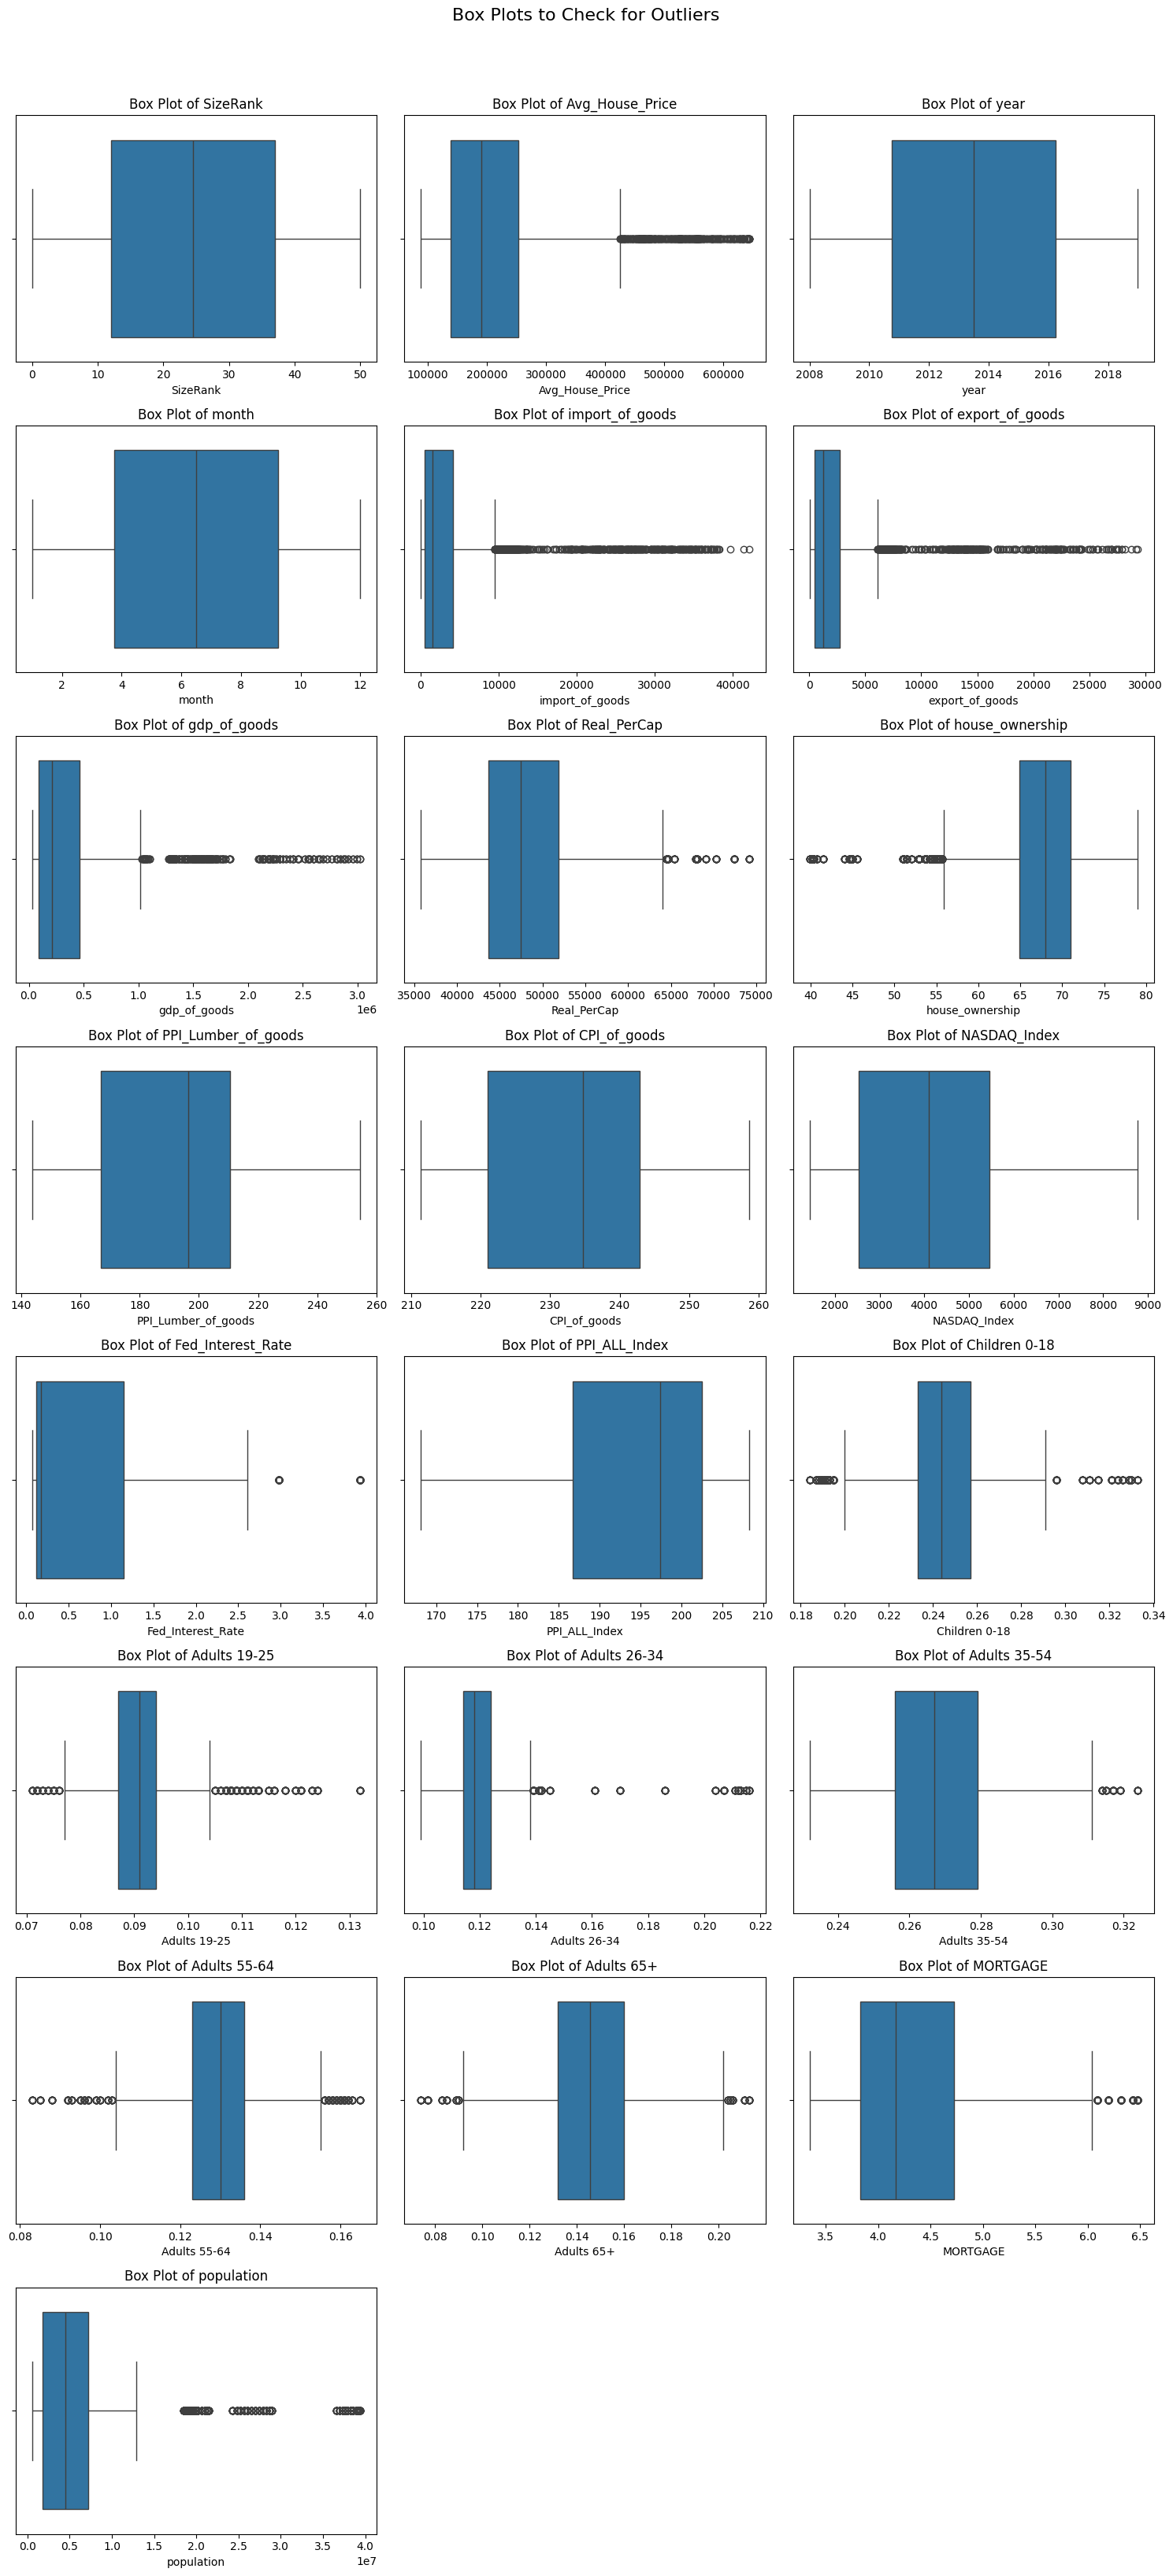

In [36]:
#Boxplot to check outliers pre-clearing the dataset

from math import ceil

# Select the numerical columns to check
numerical_cols = final_merged_df.select_dtypes(include=[np.number]).columns

# Determine the number of rows and columns for the subplot grid
n_cols = 3  # We'll use 3 columns for a compact layout
n_rows = ceil(len(numerical_cols) / n_cols)

# Create the subplots
fig, axes = plt.subplots(
    nrows=int(n_rows), ncols=n_cols,
    figsize=(5 * n_cols, 4 * n_rows)
)
fig.suptitle('Box Plots to Check for Outliers', y=1.02, fontsize=16)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Draw a box plot for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=final_merged_df[col], ax=axes_flat[i])
    axes_flat[i].set_title(f'Box Plot of {col}')
    axes_flat[i].set_xlabel(col)

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

In [37]:
#Clean dataset from outliers

# Select only the numerical columns
numerical_cols = final_merged_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the IQR for each numerical column
Q1 = final_merged_df[numerical_cols].quantile(0.20)
Q3 = final_merged_df[numerical_cols].quantile(0.80)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask to identify rows without outliers
# A row is considered an outlier if any of its numerical columns have an outlier value
outlier_mask = ~((final_merged_df[numerical_cols] < lower_bound) | (final_merged_df[numerical_cols] > upper_bound)).any(axis=1)

# Filter the DataFrame to remove rows containing outliers
final_merged_df_no_outliers = final_merged_df[outlier_mask].copy()

print("Shape of the DataFrame before outlier removal:", final_merged_df.shape)
print("Shape of the DataFrame after outlier removal:", final_merged_df_no_outliers.shape)

Shape of the DataFrame before outlier removal: (7200, 23)
Shape of the DataFrame after outlier removal: (6066, 23)


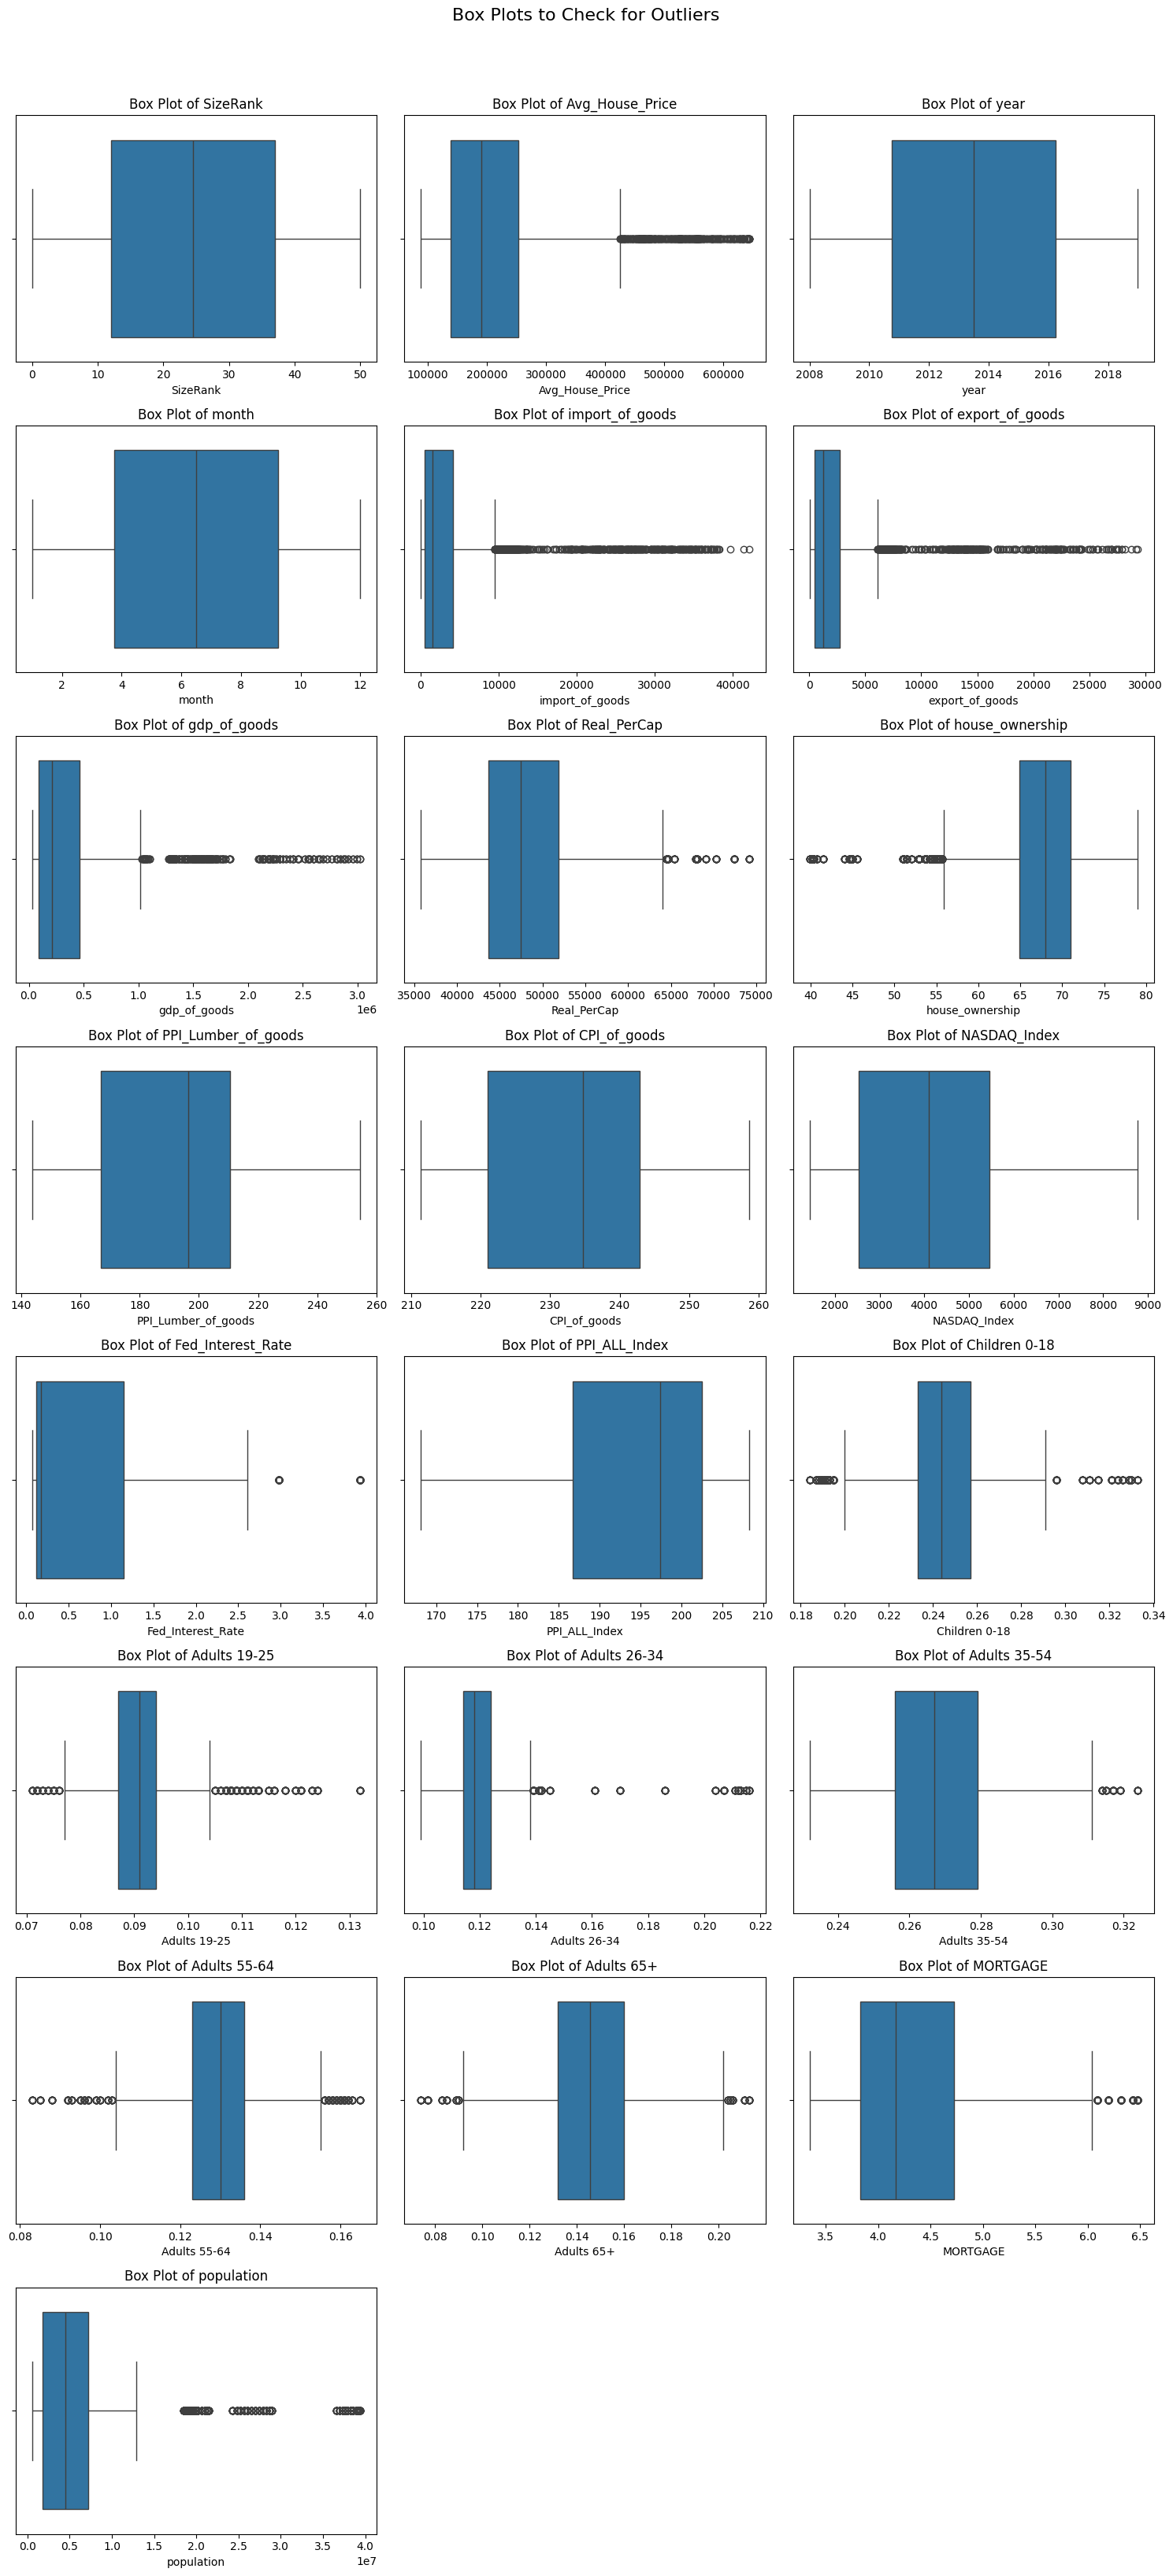

In [38]:
#Boxplot to check outliers post clearing the dataset


from math import ceil

# Select the numerical columns to check
numerical_cols = final_merged_df.select_dtypes(include=[np.number]).columns

# Determine the number of rows and columns for the subplot grid
n_cols = 3  # We'll use 3 columns for a compact layout
n_rows = ceil(len(numerical_cols) / n_cols)

# Create the subplots
fig, axes = plt.subplots(
    nrows=int(n_rows), ncols=n_cols,
    figsize=(5 * n_cols, 4 * n_rows)
)
fig.suptitle('Box Plots to Check for Outliers', y=1.02, fontsize=16)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Draw a box plot for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=final_merged_df[col], ax=axes_flat[i])
    axes_flat[i].set_title(f'Box Plot of {col}')
    axes_flat[i].set_xlabel(col)

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# Relative Increase Dataset

From the final_dataset, we create a separate dataset to calculate the relative increase in each feature from a base date. The base date we use is 01/2008.

Using relative increase provides clean, comparable growth signals across states. It removes the bias of starting price levels and instead highlights local micro-economic factors—such as real income growth, demographic mix, and supply changes—that actually drive price movements. It also makes timing clearer by revealing key turning points.

In [39]:
# -------------------------
# 1. Load Dataset
# -------------------------
INPUT_FILE = "/content/Output/final_dataset.csv"  # <-- Change if needed
OUTPUT_DIR = "/content/Output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(INPUT_FILE)

# -------------------------
# 2. Select Absolute Features
# -------------------------
absolute_features = [
    "import_of_goods", "export_of_goods", "gdp_of_goods", "Real_PerCap",
    "house_ownership", "PPI_Lumber_of_goods", "CPI_of_goods",
    "NASDAQ_Index", "Fed_Interest_Rate", "PPI_ALL_Index",
    "Children 0-18", "Adults 19-25", "Adults 26-34",
    "Adults 35-54", "Adults 55-64", "Adults 65+", "MORTGAGE", "Avg_House_Price"
]

target_col = "Avg_House_Price"



# -------------------------
# 2. Build Relative Features
# -------------------------
# Create baseline for Jan 2008 per state
base_df = df[(df["year"] == 2008) & (df["month"] == 1)].copy()
base_df = base_df.set_index("StateName")[absolute_features]

# Merge baseline values into main dataframe
df_rel = df.merge(
    base_df,
    how="left",
    left_on="StateName",
    right_index=True,
    suffixes=("", "_base")
)

# Compute relative features = current / base
relative_features = {}
for col in absolute_features:
    rel_col = f"{col}_rel"
    df_rel[rel_col] = df_rel[col] / df_rel[f"{col}_base"]
    relative_features[col] = rel_col

# -------------------------
# 3. Build Dataset (Relative Features)
# -------------------------
dataset_relative = df_rel[["StateName", "year", "month"] + list(relative_features.values())]

# -------------------------
# 4. Save Outputs
# -------------------------
dataset_b_path = os.path.join(OUTPUT_DIR, "dataset_relative.csv")

dataset_relative.to_csv(dataset_b_path, index=False)

print(f"Dataset  saved at: {dataset_b_path} ({dataset_relative.shape})")
print("\nFeatures included in Dataset dataset_relative:")
print(list(relative_features.values()))

Dataset  saved at: /content/Output/dataset_relative.csv ((7200, 21))

Features included in Dataset dataset_relative:
['import_of_goods_rel', 'export_of_goods_rel', 'gdp_of_goods_rel', 'Real_PerCap_rel', 'house_ownership_rel', 'PPI_Lumber_of_goods_rel', 'CPI_of_goods_rel', 'NASDAQ_Index_rel', 'Fed_Interest_Rate_rel', 'PPI_ALL_Index_rel', 'Children 0-18_rel', 'Adults 19-25_rel', 'Adults 26-34_rel', 'Adults 35-54_rel', 'Adults 55-64_rel', 'Adults 65+_rel', 'MORTGAGE_rel', 'Avg_House_Price_rel']
